In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
import torch.nn as nn
import matplotlib
from PIL import Image, ImageOps

matplotlib.rcParams['figure.figsize'] = (11.75, 8.5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
class Unet(nn.Module):

    def __init__(self):
        super(Unet, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.Dropout2d(p=0.5, inplace=True),
            nn.ReLU(inplace=True)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.Dropout2d(p=0.5, inplace=True),
            nn.ReLU(inplace=True)
        )
        self.unpool4 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.decoder4 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        self.unpool3 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        self.unpool2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        self.unpool1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=2, out_channels=1, kernel_size=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        neck = self.bottleneck(self.pool4(enc4))

        dec4 = self.decoder4(torch.cat((self.unpool4(neck), enc4), dim=1))
        dec3 = self.decoder3(torch.cat((self.unpool3(dec4), enc3), dim=1))
        dec2 = self.decoder2(torch.cat((self.unpool2(dec3), enc2), dim=1))
        dec1 = self.decoder1(torch.cat((self.unpool1(dec2), enc1), dim=1))
        return dec1

## Предсказание множества горизонтов

In [4]:
def pad_data(data, divisor=16):
    shape_y, shape_x = data.shape
    padding = [None, None]
    if shape_x % divisor != 0:
        for i in range(divisor):
            if data.shape[1] % divisor == 0:
                break
            data = np.c_[data,np.zeros(data.shape[0])]
        padding[0] = -i
    if shape_y % divisor != 0:
        for i in range(divisor):
            if data.shape[0] % divisor == 0:
                break
            data = np.r_[data,[np.zeros(data.shape[1])]]
        padding[1] = -i
    return data, padding


def predict_horizon(network, data_path: str, labels_path: str, horizon_nums, device, threshold: float, slicing: list, divisor: int):
    data = np.load(data_path)['arr_0'].T
    min_data_value = np.min(data)
    max_data_value = np.max(data)
    data = (data - min_data_value) / (max_data_value - min_data_value) * 255
    data = data[slicing[0]:slicing[1],slicing[2]:slicing[3]]

    labels = np.load(labels_path)['arr_0'].T
    labels = labels[slicing[0]:slicing[1],slicing[2]:slicing[3]]

    for horizon_num in horizon_nums:
        data_slice = data[:,:,horizon_num]
        labels_slice = labels[:,:,horizon_num]
        data_slice, data_padding = pad_data(data_slice, divisor)
        # fig, ax = plt.subplots()
        # ax.imshow(data_slice, cmap='gray_r')
        # fig, ax = plt.subplots()
        # ax.imshow(labels_slice, cmap='gray_r')

        img_horizon = ImageOps.grayscale(Image.fromarray(data_slice))
        horizon = transforms.ToTensor()(img_horizon)
        horizon = horizon[None, :]
        horizon.to(device)

        output = network(horizon)
        output = output.squeeze().data.cpu().numpy()
        output = output[:data_padding[1],:data_padding[0]]

        output[output >= threshold] = 1
        output[output < threshold] = 0

        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 20))
        ax[0].set_title("Predicted")
        ax[0].imshow(output)
        ax[1].set_title("Actual")
        ax[1].imshow(labels_slice)


THRESHOLD = 0.5
weights_path = os.path.join('data', 'weights', 'Best_ACC_epoch39.pth.gz')

# подгрузка модели нейросети
model = Unet()
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval();

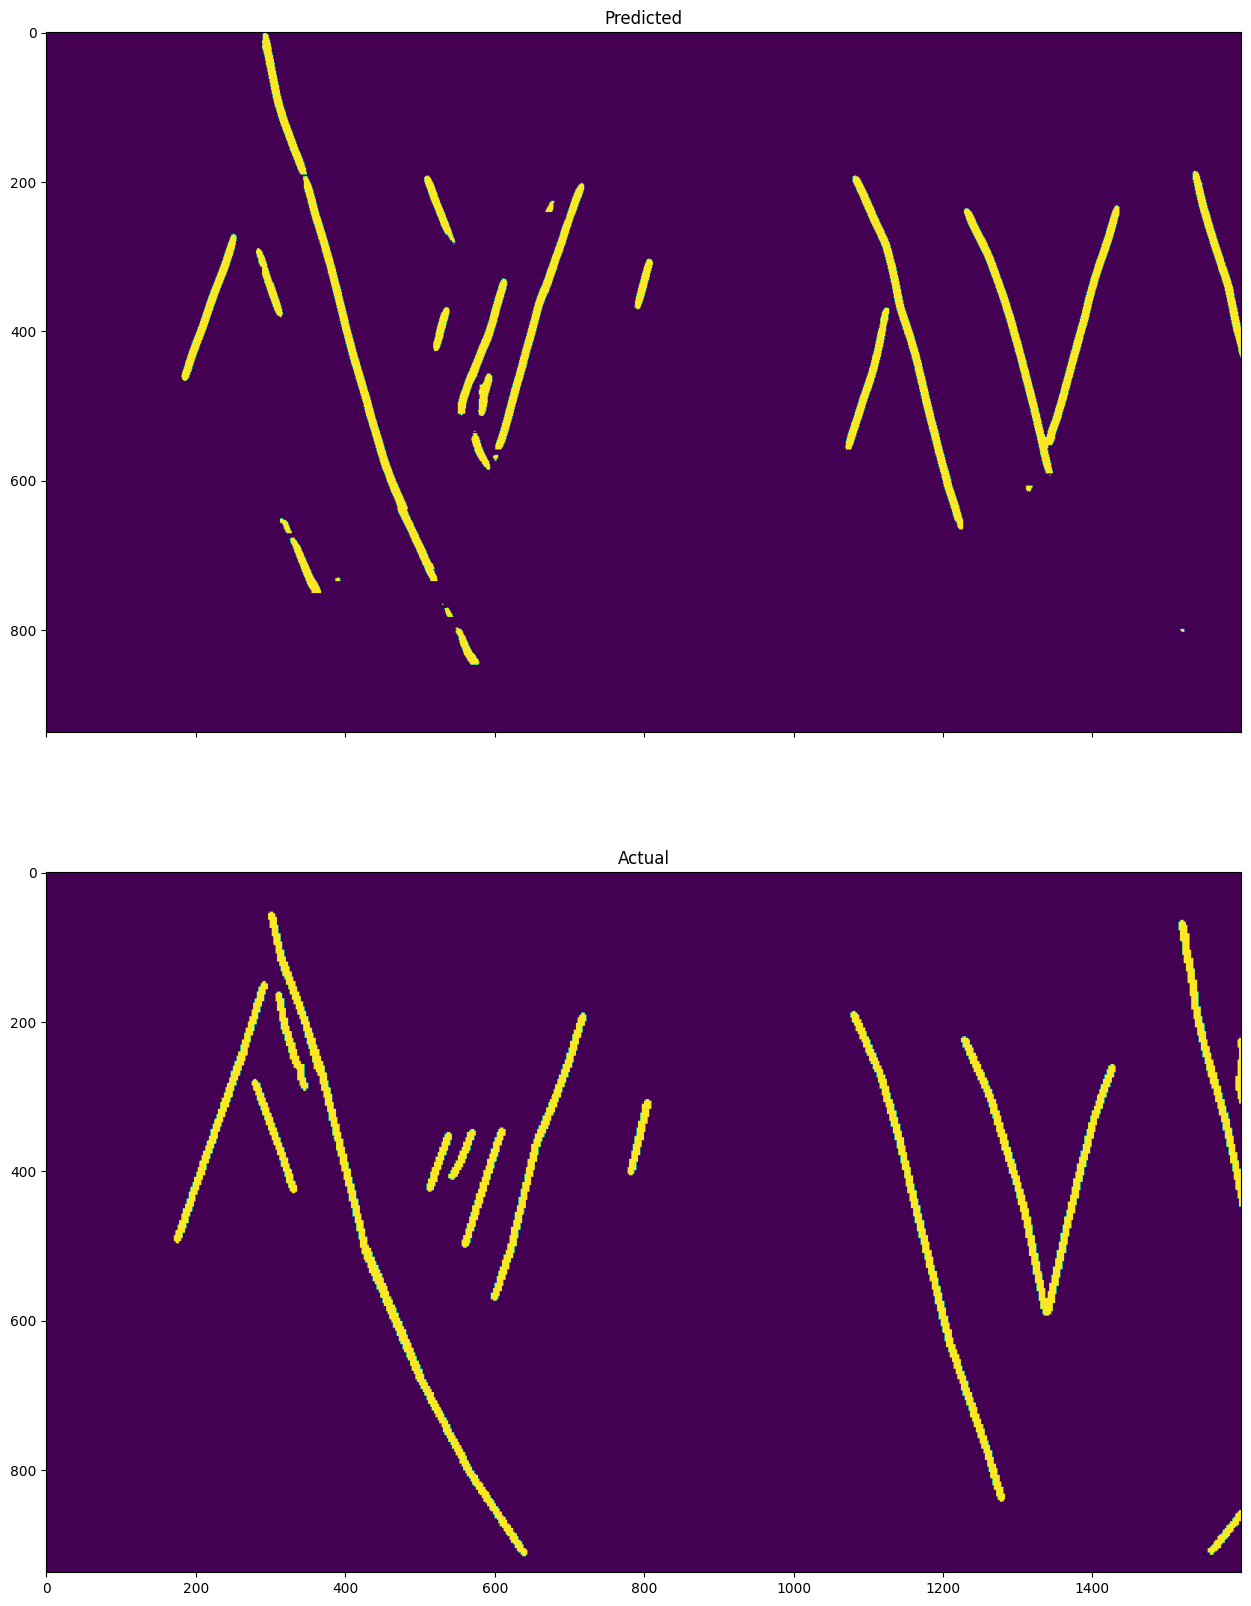

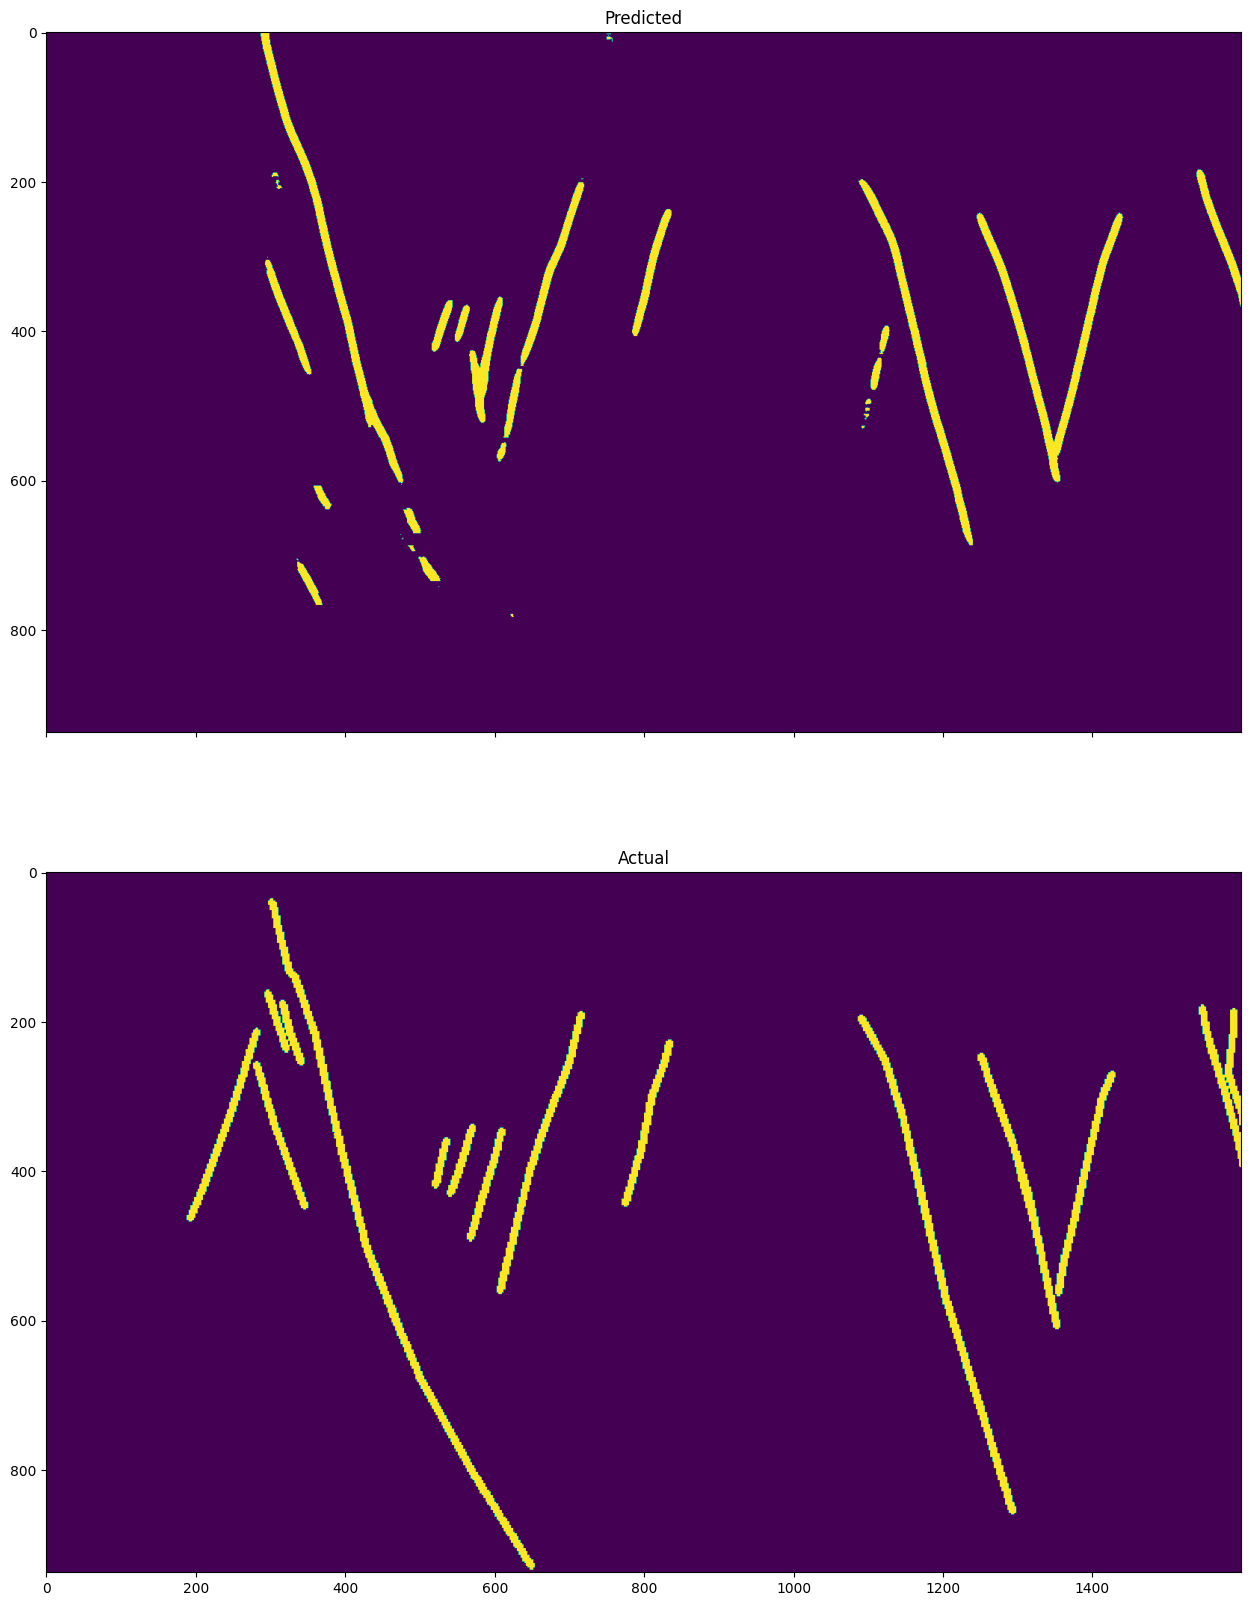

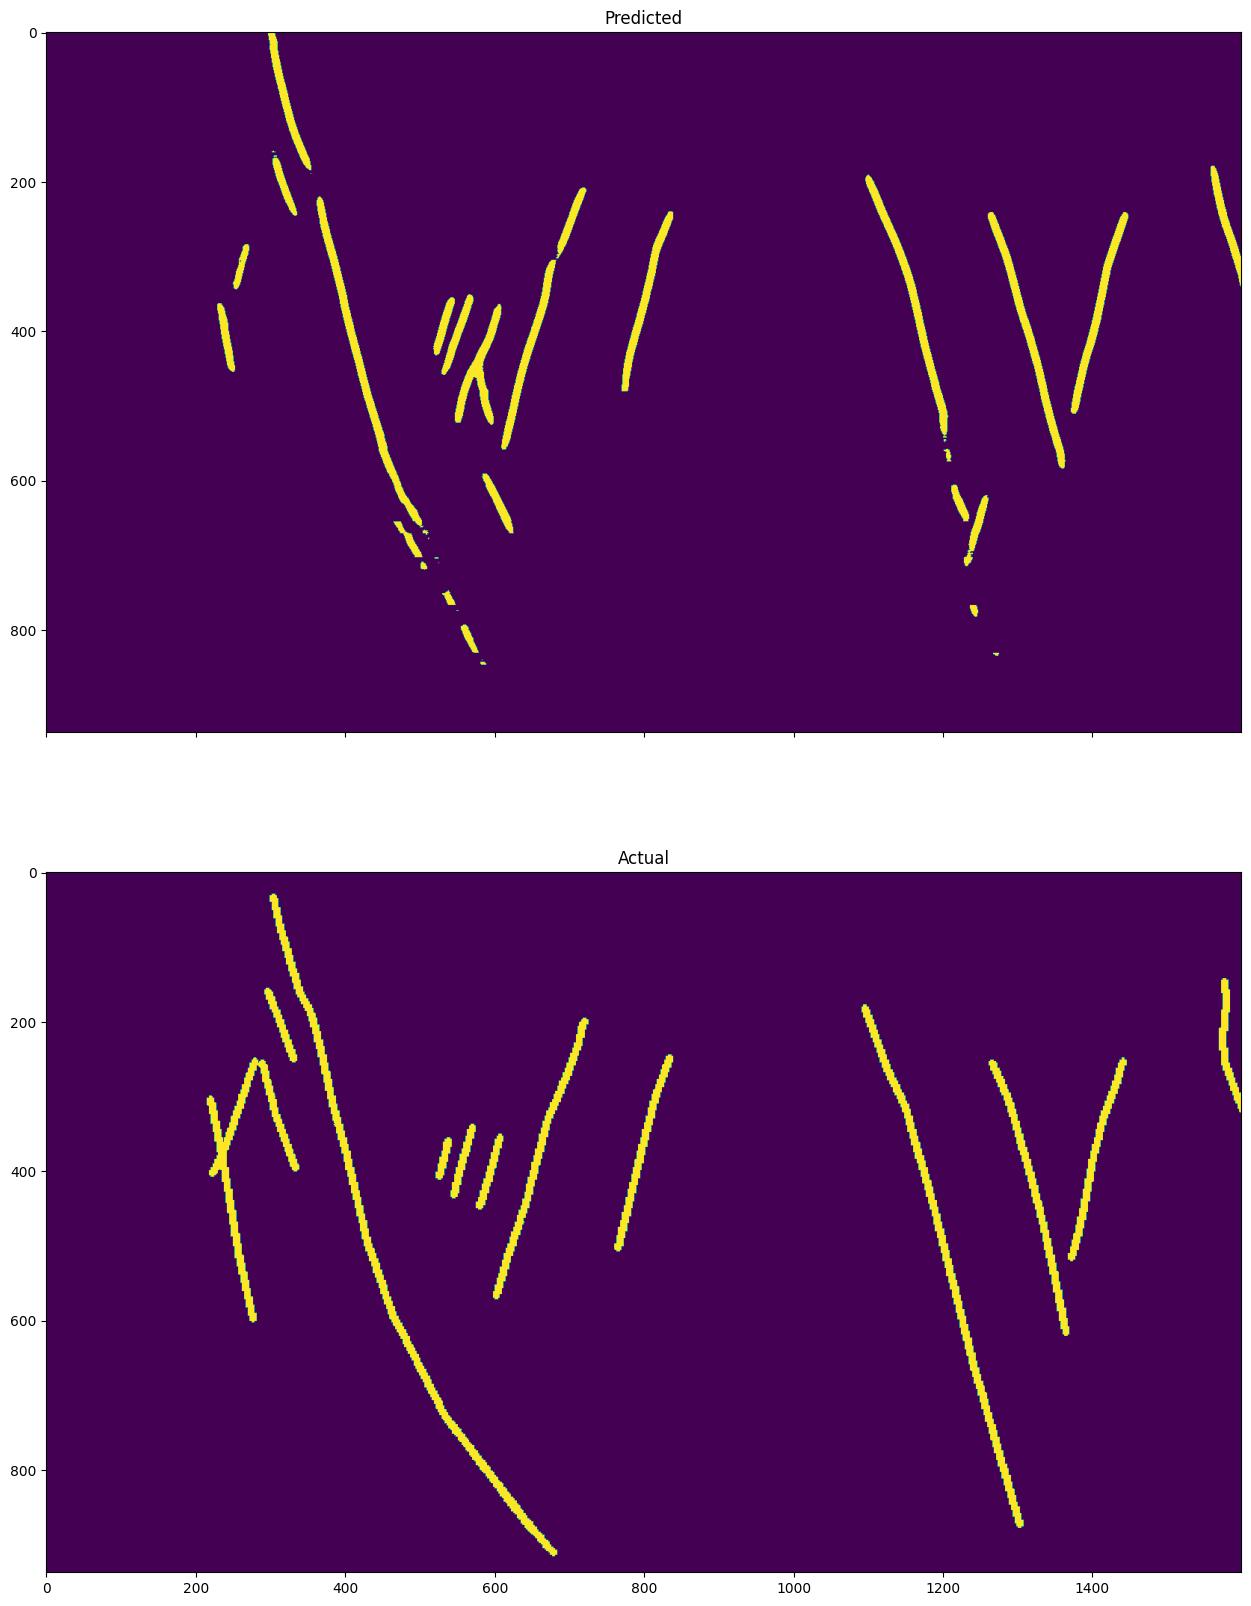

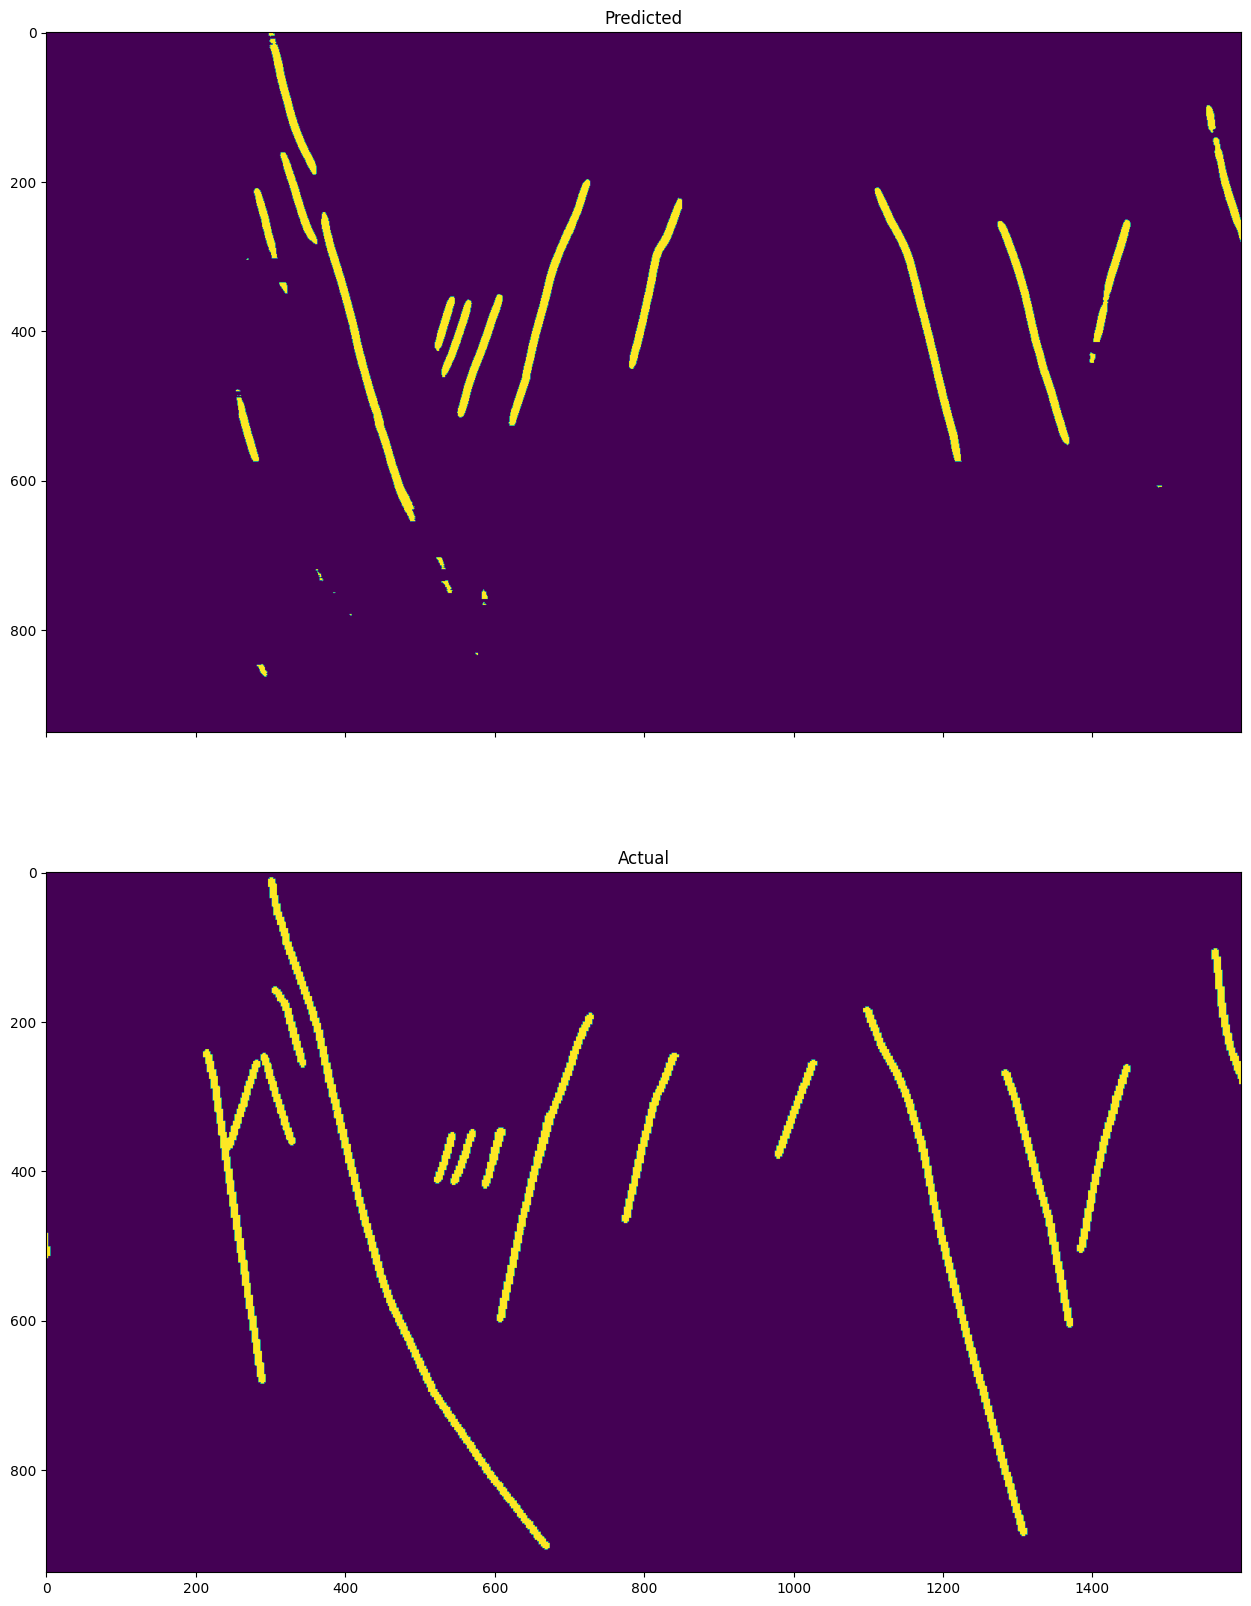

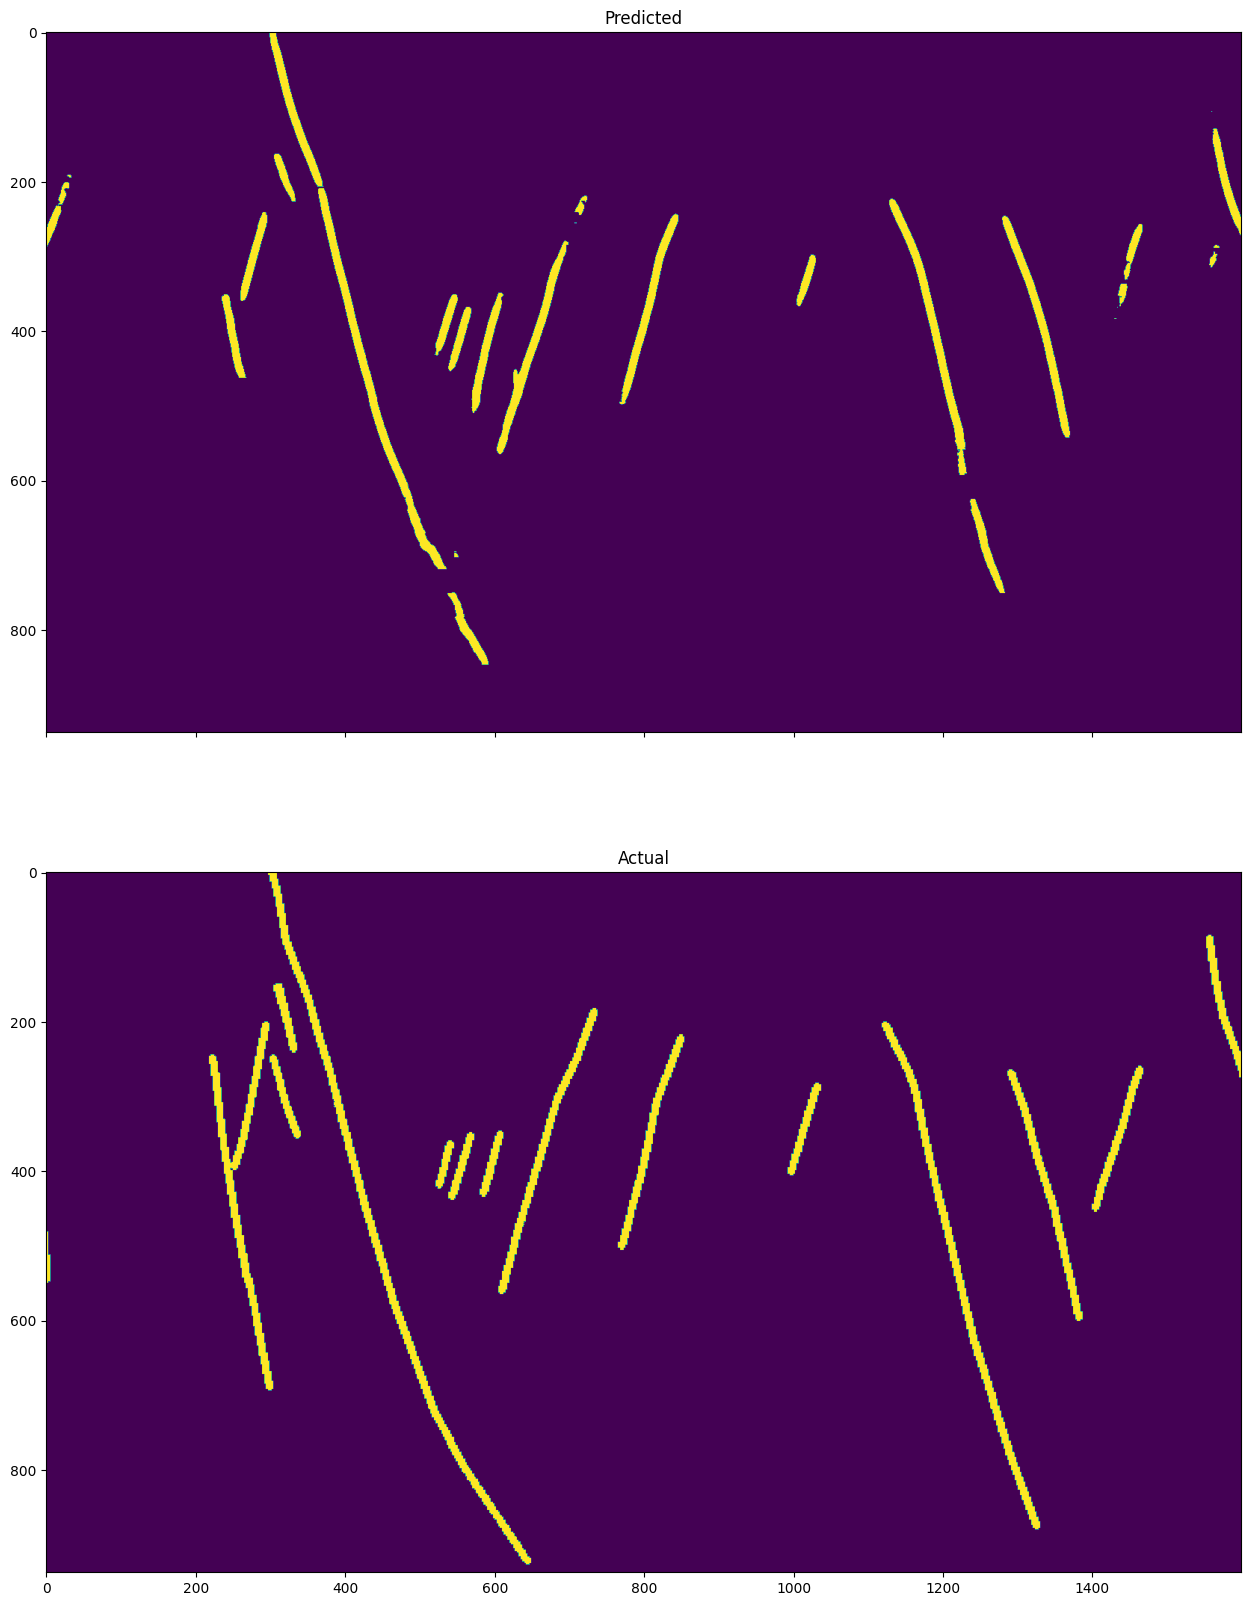

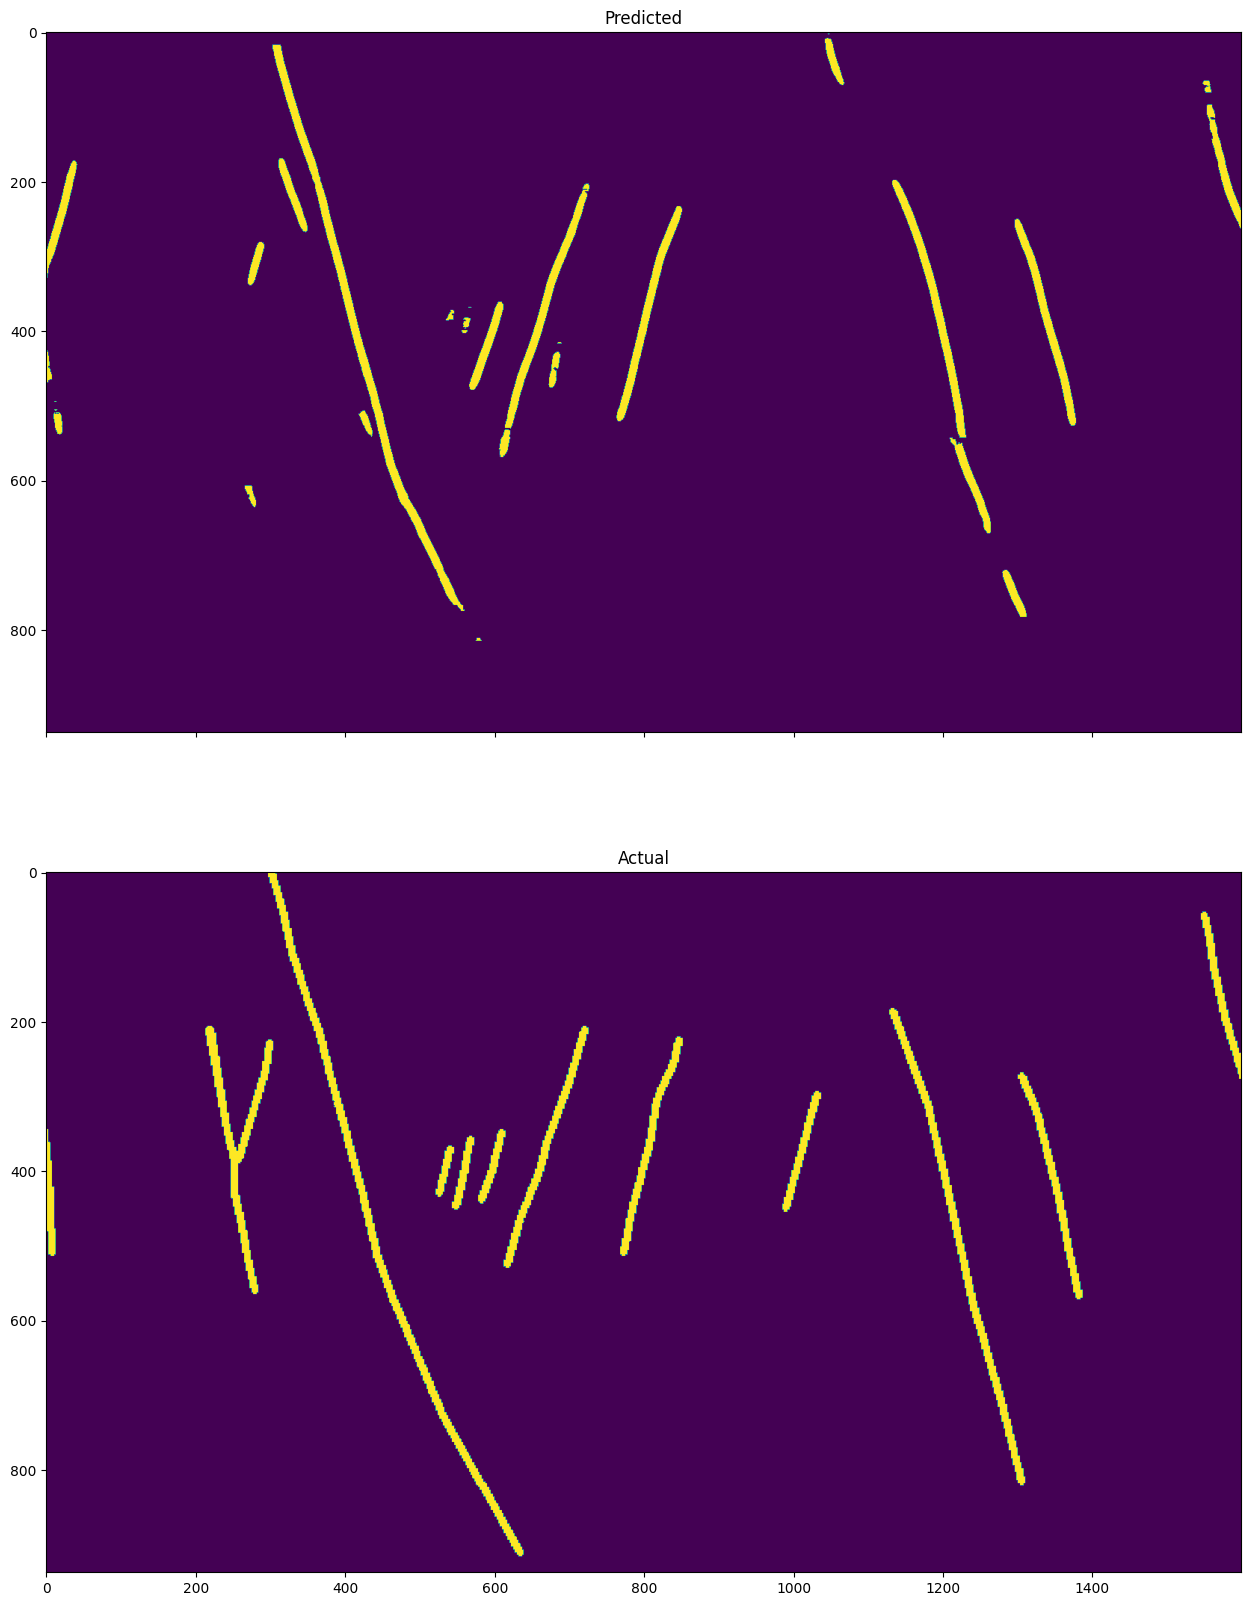

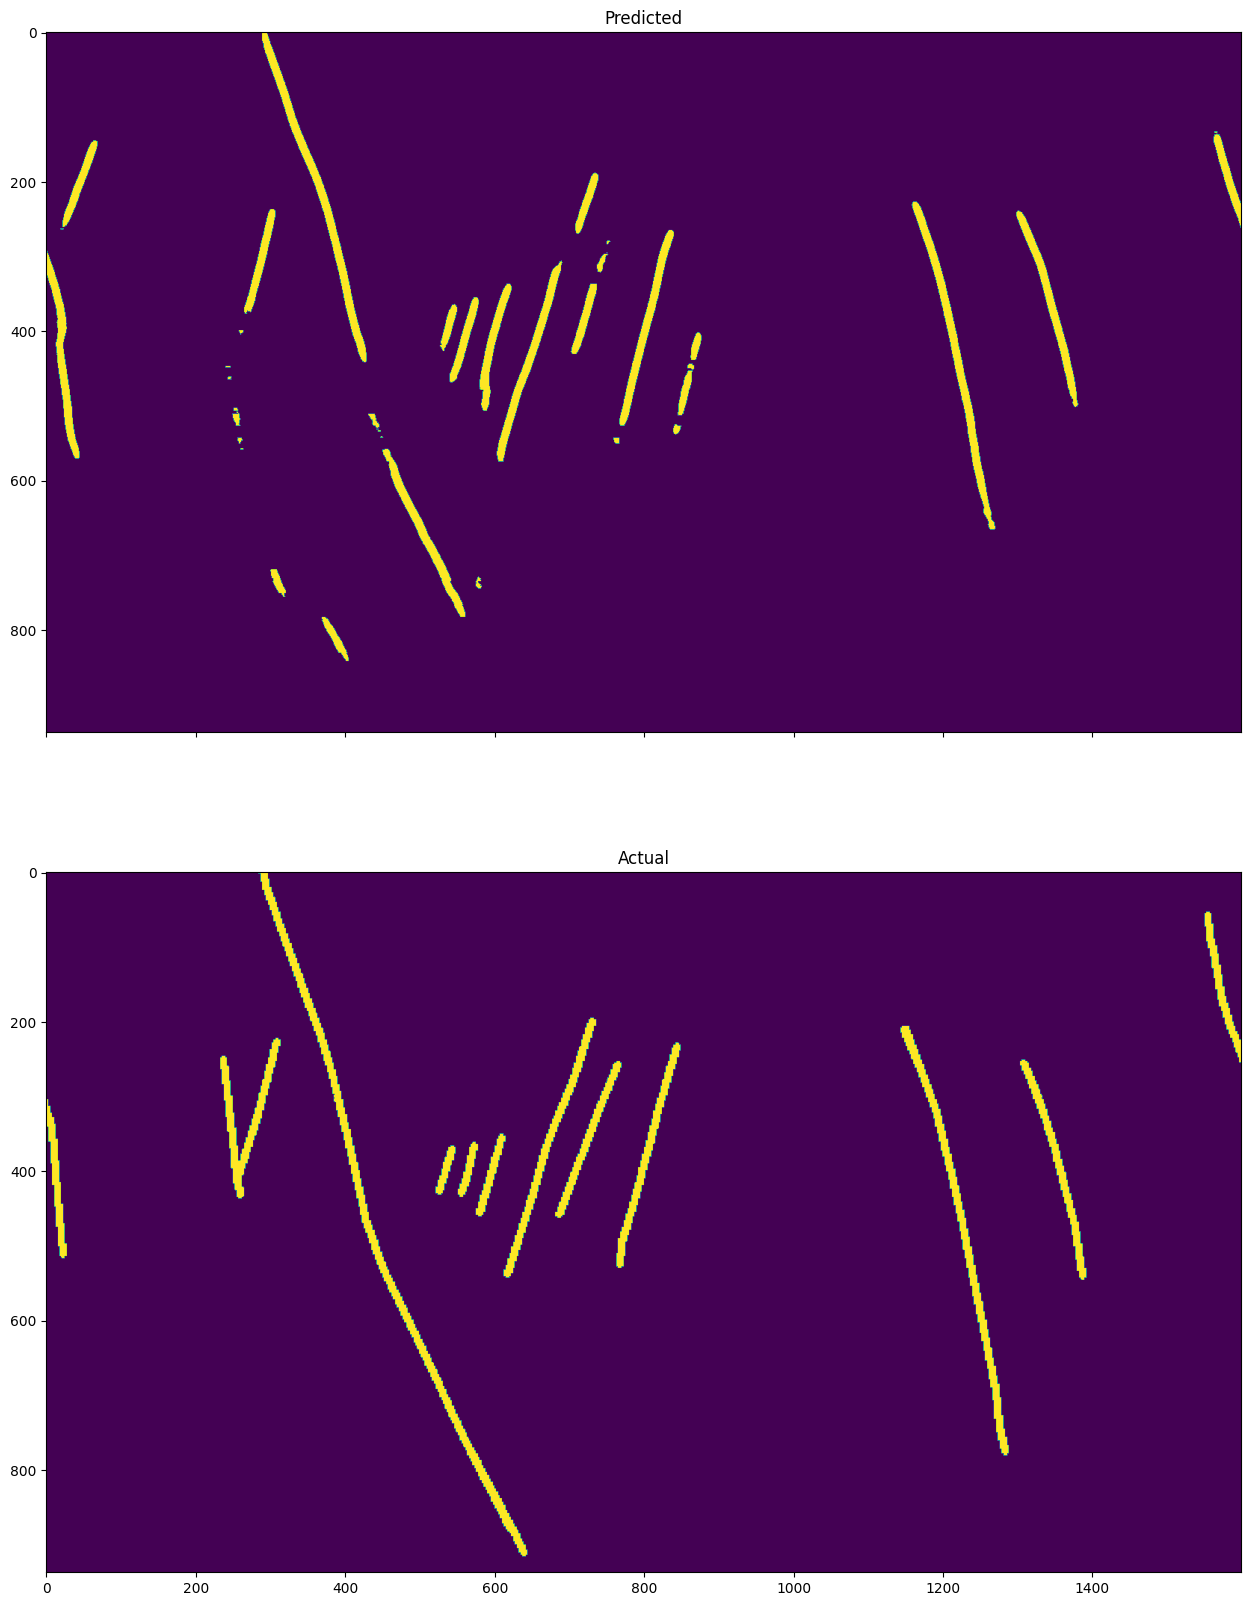

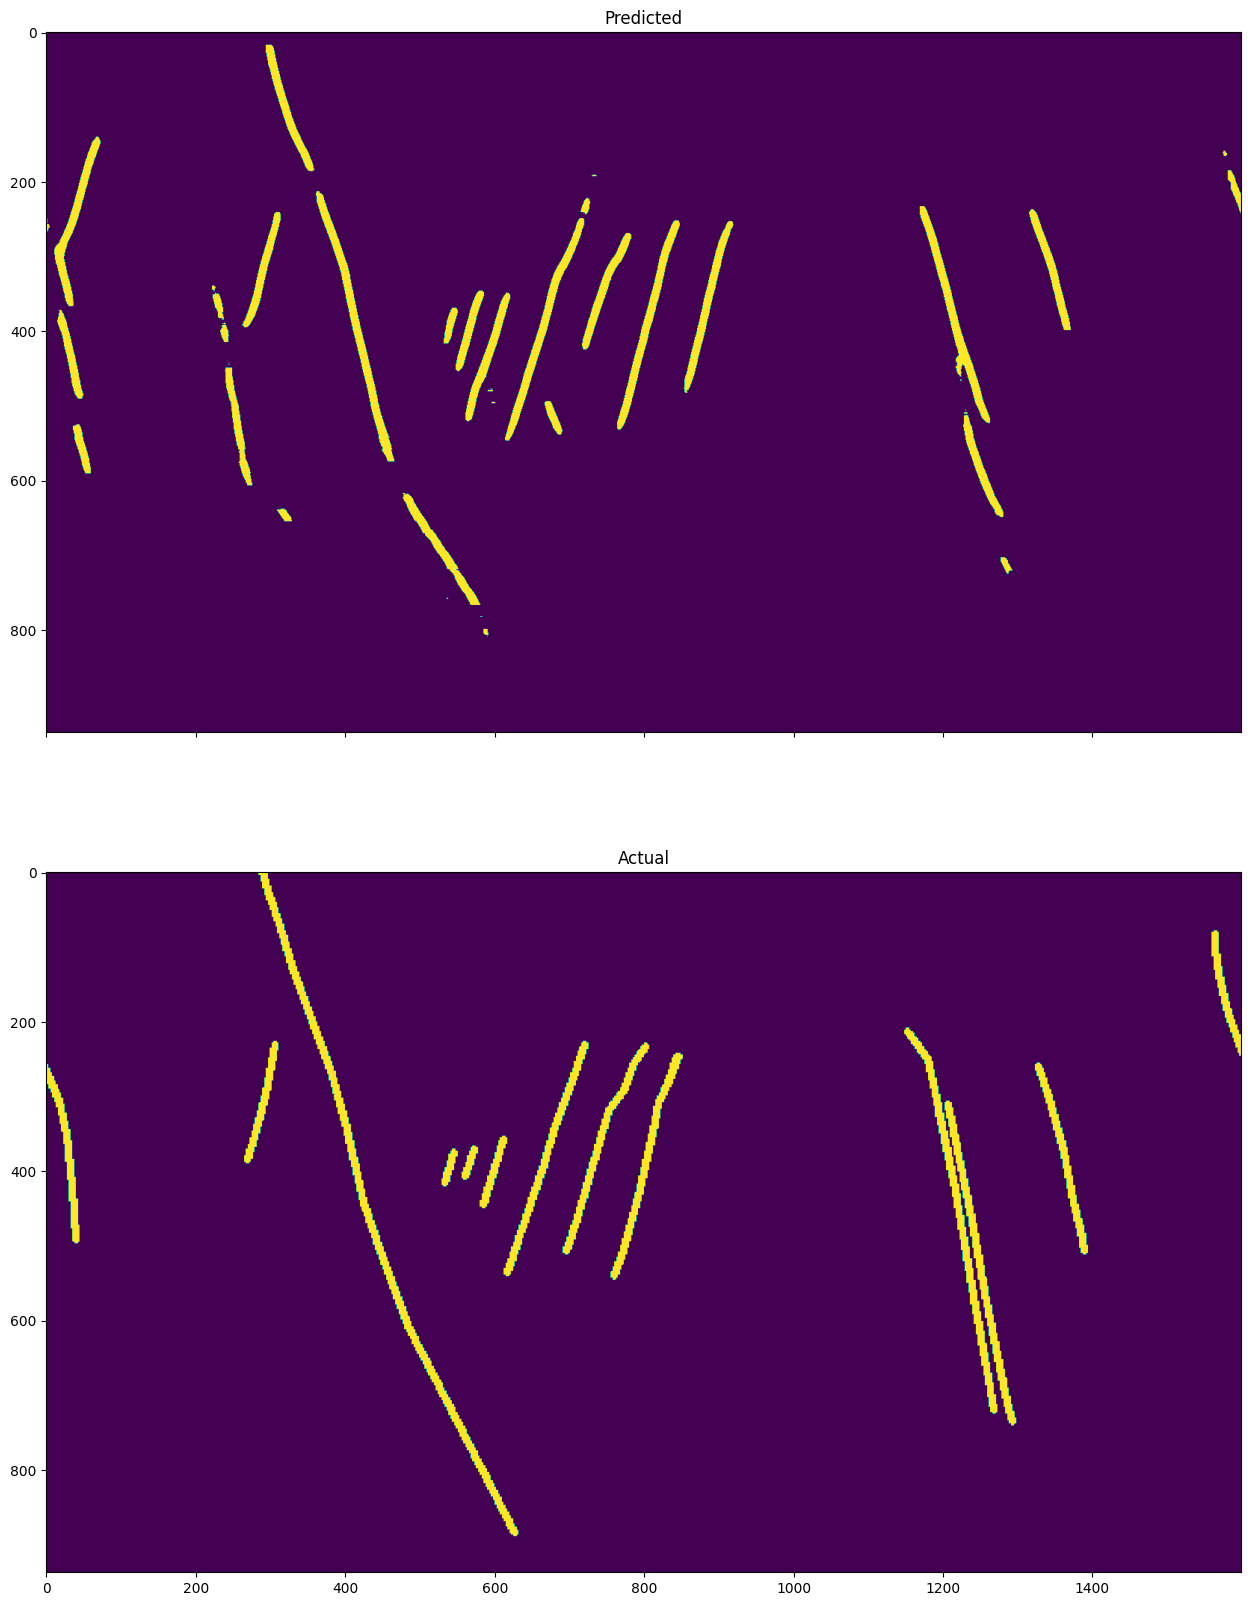

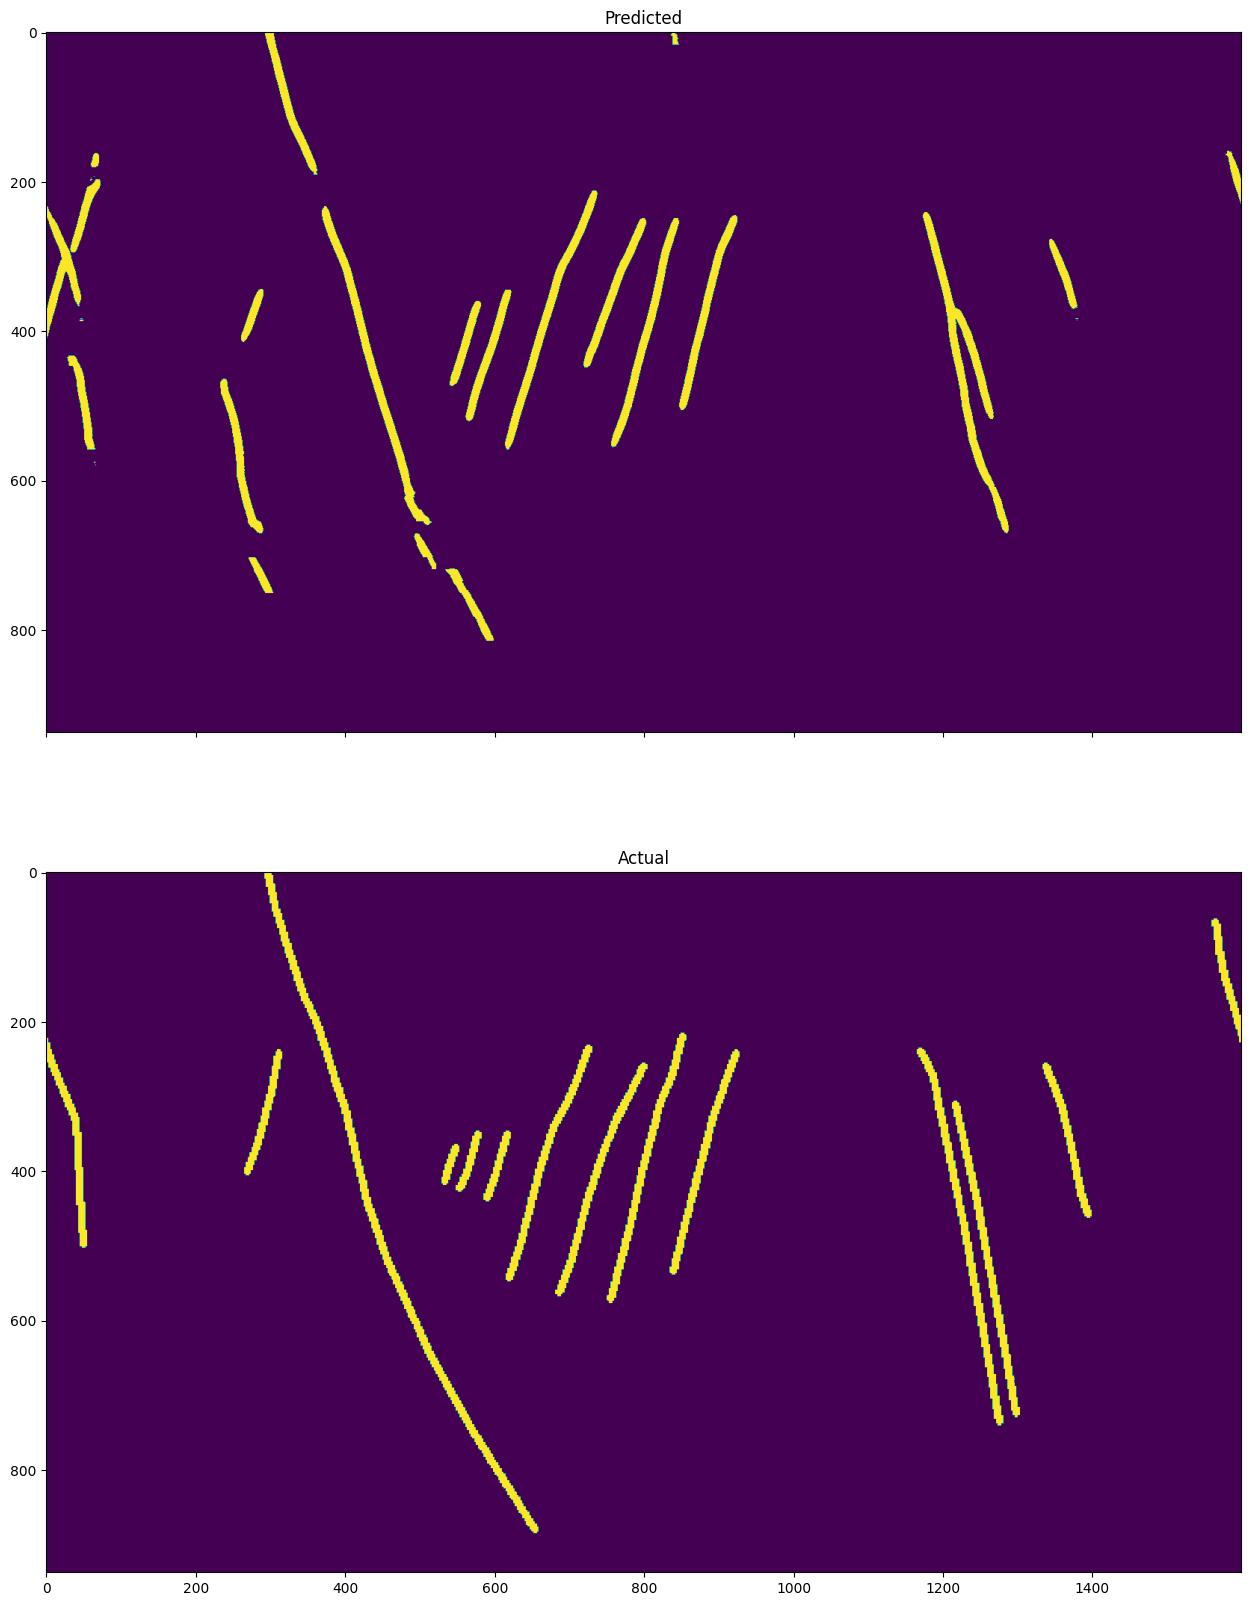

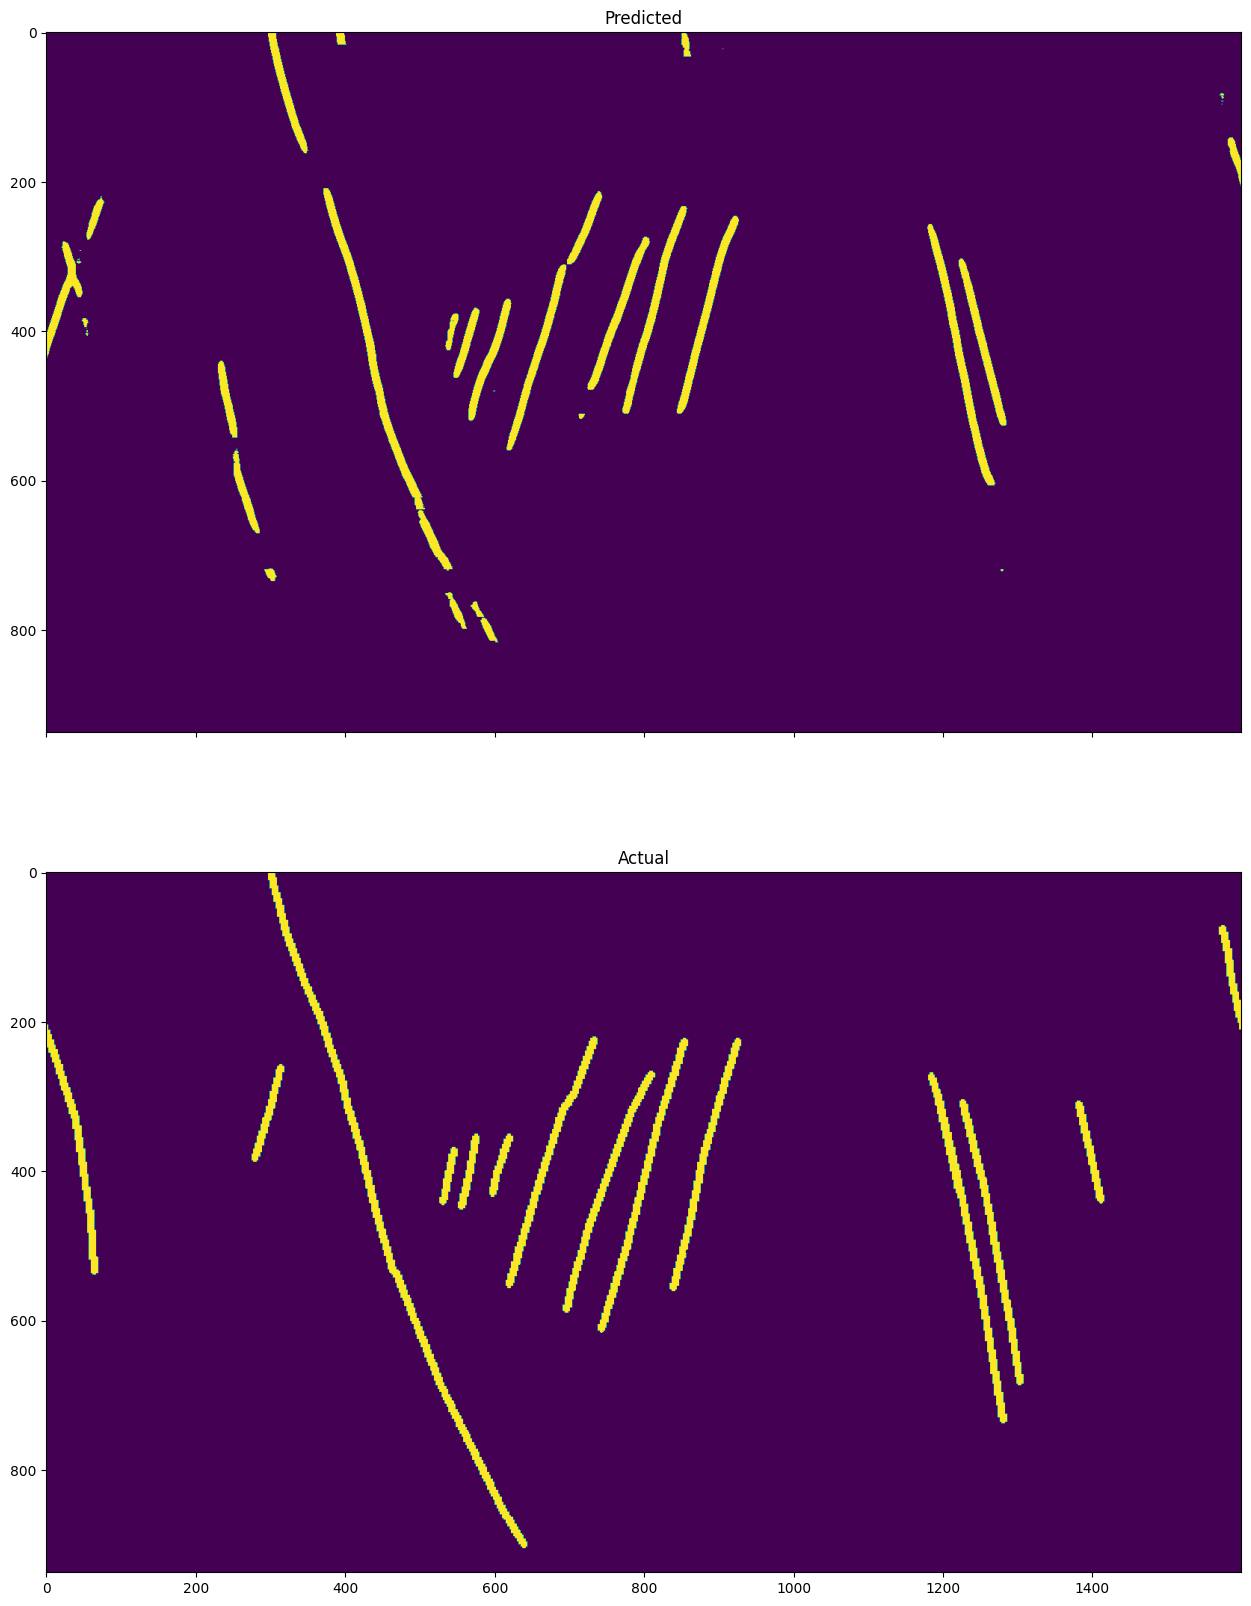

In [5]:
seis_path = os.path.join('data', 'raw', 'seistest1.npz')
fault_path = os.path.join('data', 'raw', 'faulttest1.npz')

predict_horizon(model, seis_path, fault_path, range(0, 100, 10), device, THRESHOLD, slicing=[600, None, 400, 2000], divisor=16)